In [1]:
pip install mysql-connector-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments') , # Added payments.csv for specific handling
    ('order_items.csv','order_items')
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Sharvari@1232',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = "C:/Users/sujit/OneDrive/Desktop/Ecommerce"


def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Sharvari@1232',
    database='ecommerce'
)
cur = db.cursor()




# Queries

# List all unique cities where customers are located. 

In [4]:
query = """ select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

data


[('franca',),
 ('sao bernardo do campo',),
 ('sao paulo',),
 ('mogi das cruzes',),
 ('campinas',),
 ('jaragua do sul',),
 ('timoteo',),
 ('curitiba',),
 ('belo horizonte',),
 ('montes claros',),
 ('rio de janeiro',),
 ('lencois paulista',),
 ('caxias do sul',),
 ('piracicaba',),
 ('guarulhos',),
 ('pacaja',),
 ('florianopolis',),
 ('aparecida de goiania',),
 ('santo andre',),
 ('goiania',),
 ('cachoeiro de itapemirim',),
 ('sao jose dos campos',),
 ('sao roque',),
 ('camacari',),
 ('resende',),
 ('sumare',),
 ('novo hamburgo',),
 ('sao luis',),
 ('sao jose',),
 ('santa barbara',),
 ('ribeirao preto',),
 ('ituiutaba',),
 ('taquarituba',),
 ('sao jose dos pinhais',),
 ('barrinha',),
 ('parati',),
 ('dourados',),
 ('trindade',),
 ('cascavel',),
 ('fortaleza',),
 ('brasilia',),
 ('pelotas',),
 ('porto alegre',),
 ('salto',),
 ('jundiai',),
 ('cacapava',),
 ('sao vicente',),
 ('uberlandia',),
 ('botelhos',),
 ('sao goncalo',),
 ('araucaria',),
 ('nova iguacu',),
 ('areia branca',),
 ('campo

# Count the number of orders placed in 2017.

In [5]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp)=2017"""

cur.execute(query)

data = cur.fetchall()

data

"Total orders placed in year 2017 are" , data[0][0]

('Total orders placed in year 2017 are', 405909)

# Find the total sales per category

In [25]:
query = """ select products.product_category category, 
round(sum(payments.payment_value),1)sales  
from products join order_items
on products.product_id=order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category"""

cur.execute(query)

data = cur.fetchall()

df=pd.DataFrame(data, columns=["Category","Sales"])
df

,Category,Sales
0,perfumery,72970367.0
1,Furniture Decoration,205945400.4
2,telephony,70111015.3
3,bed table bath,246607728.6
4,automotive,122730383.7
...,...,...
69,cds music dvds,172717.9
70,La Cuisine,419548.3
71,Fashion Children's Clothing,113136.5
72,PC Gamer,313117.9


# Calculate the percentage of orders that were paid in installments. 

In [7]:
query = """ select (sum(case when payment_installments >=1 then 1 else 0 end ))/count(*)*100 from payments"""

cur.execute(query)

data = cur.fetchall()

data

"The percentage of orders that were paid in installments",data[0][0]


('The percentage of orders that were paid in installments', Decimal('99.9981'))

# Count the number of customers from each state.

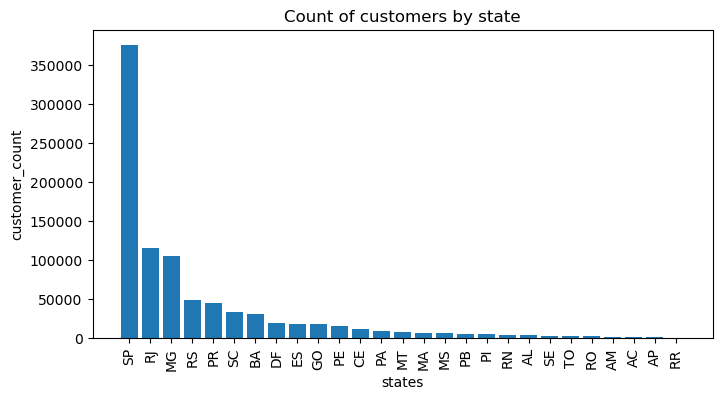

In [8]:
query = """ select customer_state, count(customer_id)
from customers group by customer_state"""

cur.execute(query)

data = cur.fetchall()

data

df=pd.DataFrame(data,columns=["State","customer_count"])
df=df.sort_values(by="customer_count", ascending=False )
plt.figure(figsize=(8,4))
plt.bar(df["State"] ,df["customer_count"])

plt.xticks(rotation=90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of customers by state")
plt.show()




# Calculate the number of orders per month in 2018

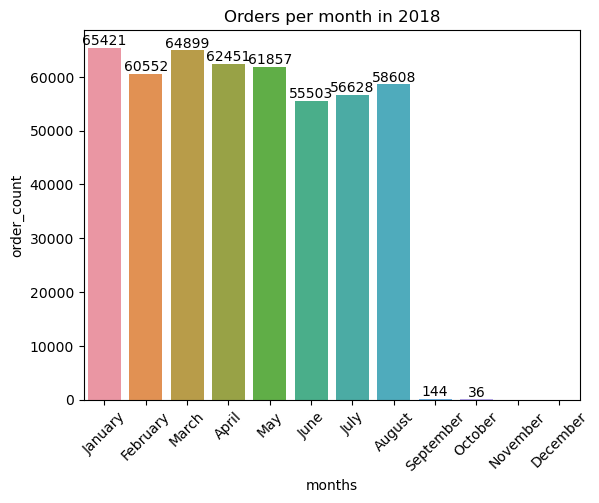

In [9]:
query = """ select monthname(order_purchase_timestamp) months,
count(order_id) order_count from orders where year(order_purchase_timestamp )=2018
group by months """

cur.execute(query)

data = cur.fetchall()

df=pd.DataFrame(data, columns=["months","order_count"])
o=["January","February","March","April","May", "June","July","August","September","October","November","December"]
ax=sns.barplot(x=df["months"],y=df["order_count"],data=df,order=o)
plt.xticks(rotation=45)

ax.bar_label(ax.containers[0])
plt.title("Orders per month in 2018")
             
plt.show()

# Find the average number of products per order,grouped by customer city.

In [10]:
query = """ with count_per_order as
(select orders.order_id,orders.customer_id,count(order_items.order_id) as oc
from orders join order_items
on orders.order_id= order_items.order_id
group by orders.order_id, orders.customer_id)


select customers.customer_city , round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id 
group by customers.customer_city order by average_orders """

cur.execute(query)

data = cur.fetchall()
df=pd.DataFrame(data, columns=["customer_city", "average products per order"])
df


,customer_city,average products per order
0,divinopolis de goias,36.00
1,sao benedito do rio preto,36.00
2,serranopolis,36.00
3,brotas de macaubas,36.00
4,tunapolis,36.00
...,...,...
4105,matias olimpio,180.00
4106,candido godoi,216.00
4107,datas,216.00
4108,celso ramos,234.00


# Identify the correlation between product price and the number of times a product has been purchased.

In [11]:

import numpy as np 
query = """ select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id =order_items.product_id
group by products.product_category"""

cur.execute(query)

data = cur.fetchall()
df=pd.DataFrame(data, columns=["category", "order_count", "price"])

arr1 = df["order_count"]
arr2 = df["price"]
a=np.corrcoef([arr1,arr2])

print("The correlation is", a[0][1])

The correlation is -0.10631514167157562


In [12]:
#the correlation is neutral. The value of correlation should be between -1 to 1 . It is 0 so neutral.

# Calculate the total revenue generated by each seller, and rank them by revenue.

In [26]:
query = """select *, dense_rank() over (order by revenue desc)as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments

on order_items.order_id = payments.order_id
group by order_items.seller_id) as a"""

cur.execute(query)

data = cur.fetchall()
data
df=pd.DataFrame(data , columns=["seller_id","revenue","rank"])

df=df.head(10)
df


,seller_id,revenue,rank
0,7c67e1448b00f6e969d365cea6b010ab,8.114671e+06,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,4.931553e+06,2
2,4a3ca9315b744ce9f8e9374361493884,4.819924e+06,3
3,1f50f920176fa81dab994f9023523100,4.644055e+06,4
4,53243585a1d6dc2643021fd1853d8905,4.558449e+06,5
5,da8622b14eb17ae2831f4ac5b9dab84a,4.355509e+06,6
6,4869f7a5dfa277a7dca6462dcf3b52b2,4.226658e+06,7
7,955fee9216a65b617aa5c0531780ce60,3.781157e+06,8
8,fa1c13f2614d7b5c4749cbc52fecda94,3.304212e+06,9
9,7e93a43ef30c4f03f38b393420bc753a,2.962147e+06,10


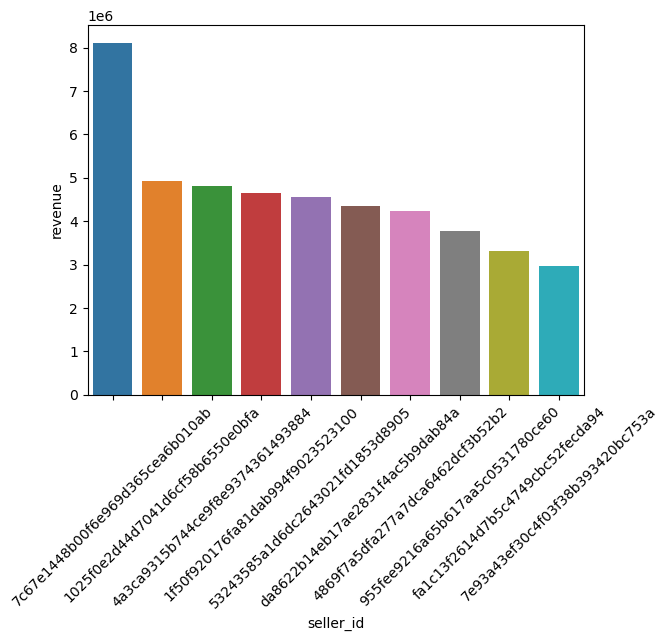

In [27]:
sns.barplot(x="seller_id" , y= "revenue", data=df)
plt.xticks(rotation=45)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [11]:
query = """select customer_id,order_purchase_timestamp,payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id,orders.order_purchase_timestamp,payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""

cur.execute(query)

data = cur.fetchall()
df=pd.DataFrame(data , columns=["customer_id","purchase_timestamp","price","moving_average"])
df

,customer_id,purchase_timestamp,price,moving_average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
3739891,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
3739892,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
3739893,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
3739894,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# Calculate the cumulative sales per month for each year.

In [24]:
query = """select years, months, payment,sum(payment)
over (order by years, months)  cumulative_sales from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),1) as payment from orders join payments


on orders.order_id = payments.order_id
group by years,months order by years , months) as a"""

cur.execute(query)

data = cur.fetchall()
df=pd.DataFrame(data, columns = ["Year","Month","Payment","Cumulative sales"])
df

,Year,Month,Payment,Cumulative sales
0,2016,9,9080.6,9080.6
1,2016,10,2127257.3,2136337.9
2,2016,12,706.3,2137044.2
3,2017,1,4985569.4,7122613.6
4,2017,2,10508688.3,17631301.9
5,2017,3,16195089.6,33826391.5
6,2017,4,15040369.1,48866760.6
7,2017,5,21345077.5,70211838.1
8,2017,6,18405949.7,88617787.8
9,2017,7,21325785.1,109943572.9


# Calculate the year-over-year growth rate of total sales.

In [35]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),1) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years,((payment- lag(payment,1) over(order by years))/  
lag(payment,1) over(order by years))* 100 from a"""

cur.execute(query)

data = cur.fetchall()
df=pd.DataFrame(data,columns=["Years","Year-over-year % growth"])
df

,Years,Year-over-year % growth
0,2016,NaN
1,2017,12112.703986
2,2018,20.000924


# Identify the top 3 customers who spent the most money in each year

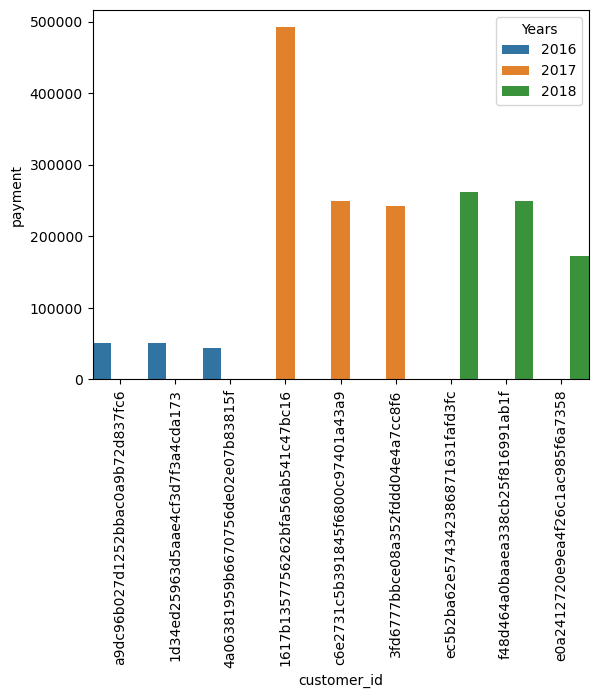

In [62]:
import seaborn as sns
query = """select years, customer_id, payment,d_rank
from 
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over (partition  by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp) ,
orders.customer_id) as a
where d_rank<=3"""


cur.execute(query)

data = cur.fetchall()
df=pd.DataFrame(data, columns = ["Years","customer_id","payment","d_rank"])
sns.barplot(x="customer_id", y="payment" ,data=df, hue="Years", width=1)
plt.xticks(rotation=90)
plt.show()